# Fleming Pipeline - ipython notebook version

### Note on astrometry.net 

Shouldn't need a key to find RA/DEC coordinates since `force_upload=False`.

If the solve keeps timing out and you have `Config.astrometry_timeout` as a large value (or `-1`) then check the timeout in `~/.astroquery/config/astroquery.cfg`.


#### How to get a key
If you do want to upload (eg if machine takes too long solving) you will need a key and add it to `~/.astroquery/config/astroquery.cfg` and `pipeline/astrometry_api_key.txt`.
The first is a config file (example layout is as below) latter is just a text file containing the key and nothing else.

[Go to the website](http://nova.astrometry.net/api_help) and sign in and follow the instructions.

Example config:
```
[astrometry_net]

api_key = XXXXX
timeout = 1200 ## 20 mins
server = http://npva.astrometry.net
```

## General imports and setup
Run this, change the config cell to suit the field that you want to run for.

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports
import pipeline
from pipeline import *
from pipeline import Pipeline

from datetime import datetime
import os

In [ ]:
# REMOVE ME WHEN NOT USING DARK MODE
import matplotlib as mpl
COLOR = "white"
#COLOR = "black"
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## A4 paper
mpl.rcParams['figure.figsize'] = [11.3, 8.7]

In [ ]:
config = Config(
    raw_image_dir = os.path.expanduser("~/mnt/jgt/2022/0301"),
    image_prefix = "l138_0",
    bias_prefix = "bias",
    n_sets = 9,
    fits_extension = ".fits",
    fits_date_format = "%Y.%m.%dT%H:%M:%S.%f",
    has_filter_in_header = False,
)

## Run the pipeline
Run using the general setup from `pipeline/Pipeline.py`.

In [ ]:
Pipeline.run(config, show_plots=True, show_errors=False)

## Pipeline breakdown
Below is a rough copy of the `Pipeline.run()` method.

Used for picking certain parts to run/rerun.
Hopefully minimal kernel restarts are needed when running.

In [ ]:
r = Reducer(config, "No filter") ## Only "No filter" for Trius

r.reduce(skip_existing=True)

In [ ]:
c = Cataloguer(config)

catalogue_image = os.path.join(config.image_dir, config.image_format_str.format(1, 1))

In [ ]:
#n_sources = c.generate_catalogue(catalogue_image, solve=True)
#c.generate_image_times()

n_sources = c.generate_catalogue(catalogue_image, solve=False)

In [ ]:
sf = ShiftFinder(config, n_sources)

sf.generate_shifts()

In [ ]:
ff = FluxFinder(config, n_sources)

In [ ]:
ff.make_light_curves()

In [ ]:
da = DataAnalyser(config)

In [ ]:
da.create_avg_curve()
ff.plot_avg_light_curve(config.avg_curve_path, show=True)

In [ ]:
ff.create_adjusted_light_curves()

In [ ]:
variable_ids = da.get_variables()
ff.plot_given_light_curves(variable_ids, adjusted=True, show=True, show_errors=False)

In [ ]:
da.output_results()
da.create_thumbnails(ff)

## Debug land

Use at your own peril.

If you change something in the `pipeline/*.py` then you need to reload the modules differently instead of with the normal imports.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports
import pipeline
from pipeline import *
from pipeline import Pipeline

from datetime import datetime
import os

In [2]:
# REMOVE ME WHEN NOT USING DARK MODE
import matplotlib as mpl
COLOR = "white"
#COLOR = "black"
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## A4 paper
mpl.rcParams['figure.figsize'] = [11.3, 8.7]

In [3]:
config = Config(
    raw_image_dir = os.path.expanduser("~/mnt/jgt/2022/0301"),
    image_prefix = "l138_0",
    bias_prefix = "bias",
    n_sets = 9,
    fits_extension = ".fits",
    fits_date_format = "%Y.%m.%dT%H:%M:%S.%f",
    has_filter_in_header = False,
)

[JOB] Started l138_0 at 16:05:21
[Pipeline] Cataloguing image ./workspace/../images/r_l138_0_1_001.fits
[Cataloguer] Filtered out 0 objects
[Cataloguer] Found 1743 suitable sources
[Cataloguer] Getting coordinate system for image './workspace/../images/r_l138_0_1_001.fits'
[Job] Finished job 'cataloguing stars' at 16:05:22 (took 0:00:01.551376)
[Pipeline] Getting variables post-adjustment
[DEBUG] listing adjusted sources
[DEBUG] listing adjusted sources
[DEBUG] listing sources
[DataAnalyser] Found 5 variables out of 1743 sources
[Job] Finished job 'post-adjustment' at 16:05:36 (took 0:00:14.048832)
[Pipeline] Plotting variable curves
[FluxFinder] Plotting light curve for source None (adjusted=False)


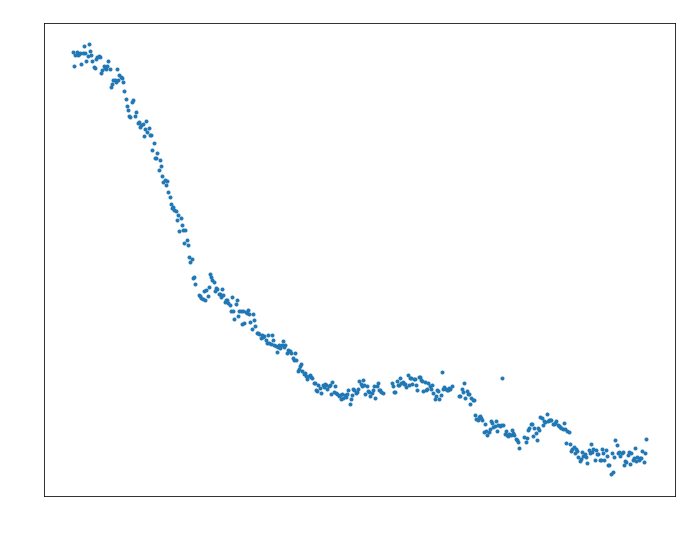

[DEBUG] listing adjusted sources
[FluxFinder] Plotting light curve for source 346 (adjusted=True)


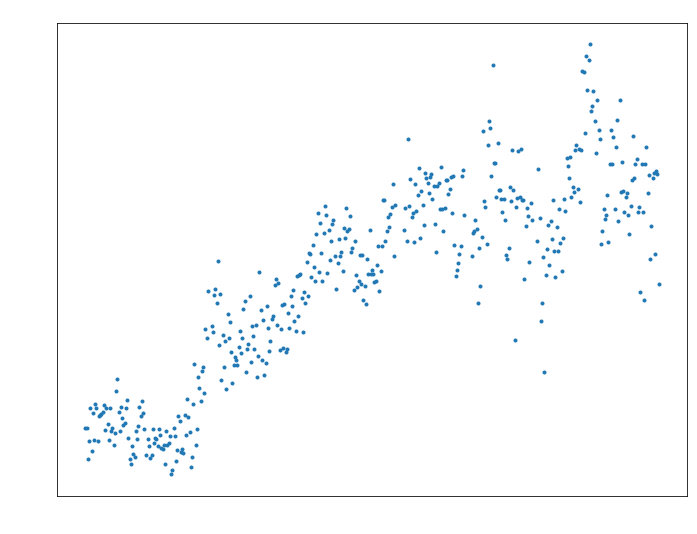

[FluxFinder] Plotting light curve for source 453 (adjusted=True)


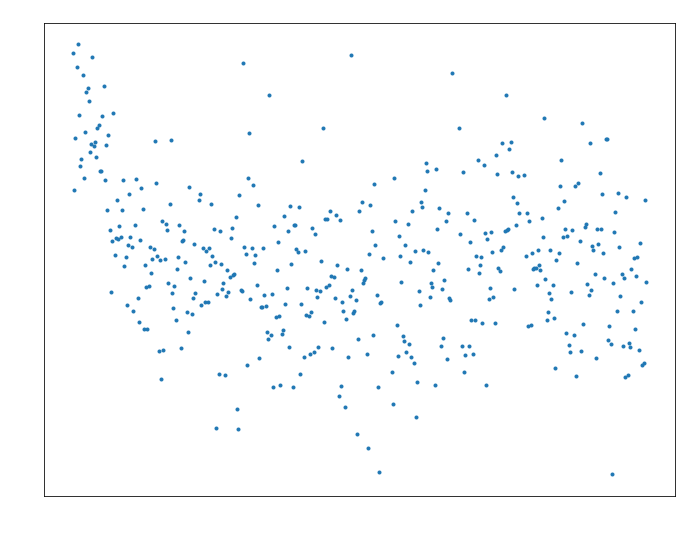

[FluxFinder] Plotting light curve for source 613 (adjusted=True)


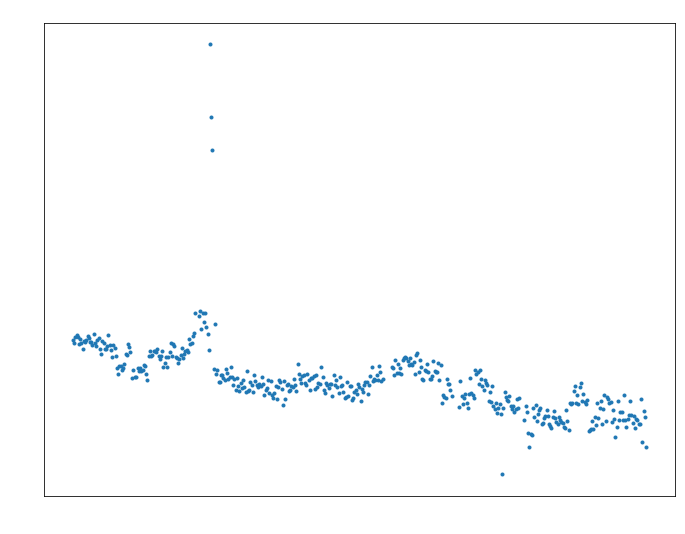

[FluxFinder] Plotting light curve for source 1024 (adjusted=True)


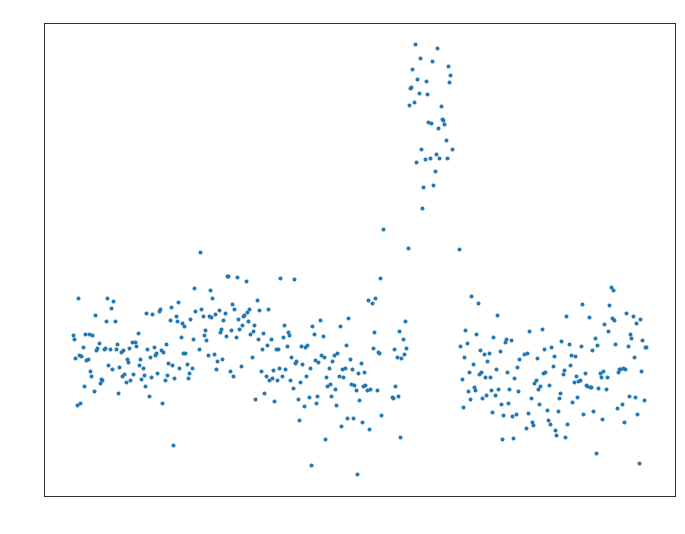

[FluxFinder] Plotting light curve for source 1402 (adjusted=True)


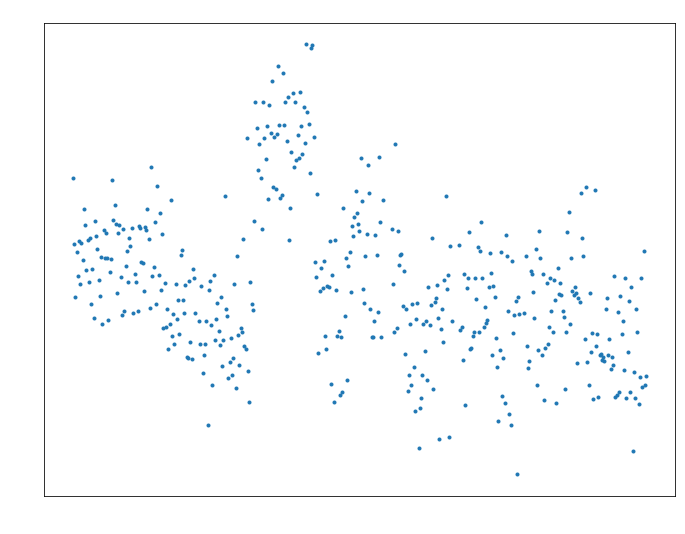

[Pipeline] Outputting results
[DataAnalyser] Making thumbnails
[DEBUG] listing sources
[DataAnalyser] Creating thumbnail for source id 0346, centroid 2244.6891,325.35581
[DataAnalyser] Creating thumbnail for source id 0453, centroid 962.93942,419.37894
[DataAnalyser] Creating thumbnail for source id 0613, centroid 192.99368,579.42263
[DataAnalyser] Creating thumbnail for source id 1024, centroid 2125.9221,996.9949
[DataAnalyser] Creating thumbnail for source id 1402, centroid 490.58027,1313.8162
[Job] Finished job 'everything for l138_0' at 16:05:38 (took 0:00:17.321765)


In [4]:
Pipeline.run_existing(config, assume_already_adjusted=True, show_plots=True, show_errors=False)